In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import svm
import numpy as np
import numpy.random as r 
import matplotlib.pyplot as plt 
import os
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Part 1: Data preprocessing


In [8]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv") 

In [9]:
data = data.drop("id", axis = 1) #remove useless features
data = data[data.gender != "Other"]
data.reset_index(drop=True, inplace=True)
data.head(15)
data["stroke"][788]

0

Filling null values

In [10]:
data["bmi"][3116]
data["stroke"].isnull().any()

False

In [11]:
bmi_data = data.groupby(["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status", "stroke"])["bmi"].mean()

avg_bmi = data["bmi"].mean()

#assign nan values to the average of samples with matching attributes
for i in range(data["bmi"].shape[0]):
  if np.isnan(data["bmi"][i]):
    data["bmi"][i] = round(bmi_data[data["gender"][i], data["hypertension"][i], data["heart_disease"][i], data["ever_married"][i], data["work_type"][i], data["Residence_type"][i], data["smoking_status"][i], data["stroke"][i]].item(),1)
    if np.isnan(data["bmi"][i]):
        data["bmi"][i] = round(avg_bmi,1)
data[data.isnull().any(axis=1)]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


### One Hot Encoding

In [12]:
# One Hot encoding Here
data_onehot = data.copy()
categorization = {
    "gender": {"Male": 0, "Female": 1},
    "ever_married": {"No":0, "Yes": 1},
    "Residence_type": {"Urban": 0, "Rural": 1}
}
data_onehot = data_onehot.replace(categorization)

smoking_oh = pd.get_dummies(data_onehot['smoking_status'])
worktype_oh = pd.get_dummies(data_onehot['work_type'])
data_onehot = data_onehot.drop('smoking_status', axis=1)
data_onehot = data_onehot.drop('work_type', axis=1)
data_onehot = data_onehot.join(smoking_oh)
data_onehot = data_onehot.join(worktype_oh)
data_onehot

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Unknown,formerly smoked,never smoked,smokes,Govt_job,Never_worked,Private,Self-employed,children
0,0,67.0,0,1,1,0,228.69,36.6,1,0,1,0,0,0,0,1,0,0
1,1,61.0,0,0,1,1,202.21,26.3,1,0,0,1,0,0,0,0,1,0
2,0,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,1,0,0
3,1,49.0,0,0,1,0,171.23,34.4,1,0,0,0,1,0,0,1,0,0
4,1,79.0,1,0,1,1,174.12,24.0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,1,80.0,1,0,1,0,83.75,33.2,0,0,0,1,0,0,0,1,0,0
5105,1,81.0,0,0,1,0,125.20,40.0,0,0,0,1,0,0,0,0,1,0
5106,1,35.0,0,0,1,1,82.99,30.6,0,0,0,1,0,0,0,0,1,0
5107,0,51.0,0,0,1,1,166.29,25.6,0,0,1,0,0,0,0,1,0,0


In [13]:
# Index of what we want to predict.
y_col_ix = data_onehot.columns.get_loc("stroke")
y_col_ix

8

In [14]:
# Numpy version of the data
data_oh_numpy = data_onehot.to_numpy()
data_oh_numpy

array([[ 0., 67.,  0., ...,  1.,  0.,  0.],
       [ 1., 61.,  0., ...,  0.,  1.,  0.],
       [ 0., 80.,  0., ...,  1.,  0.,  0.],
       ...,
       [ 1., 35.,  0., ...,  0.,  1.,  0.],
       [ 0., 51.,  0., ...,  1.,  0.,  0.],
       [ 1., 44.,  0., ...,  0.,  0.,  0.]])

### Splitting the Data

In [15]:
X = np.hstack((data_oh_numpy[:, :y_col_ix], data_oh_numpy[:, y_col_ix+1:]))
y = data_oh_numpy[:, y_col_ix]

### Feature Transformation : Zero-Center + Normalize



In [16]:
# Standard Scaling (Zero mean + unit variance)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[-1.18979109,  1.05124201, -0.32863749, ...,  0.86444434,
        -0.43693145, -0.39415678],
       [ 0.84048369,  0.78588869, -0.32863749, ..., -1.15681248,
         2.28868854, -0.39415678],
       [-1.18979109,  1.6261742 , -0.32863749, ...,  0.86444434,
        -0.43693145, -0.39415678],
       ...,
       [ 0.84048369, -0.3639757 , -0.32863749, ..., -1.15681248,
         2.28868854, -0.39415678],
       [-1.18979109,  0.34363316, -0.32863749, ...,  0.86444434,
        -0.43693145, -0.39415678],
       [ 0.84048369,  0.03405428, -0.32863749, ..., -1.15681248,
        -0.43693145, -0.39415678]])

In [35]:
# 60% Train, 20% Test, 20% Val
X_train_80, X_test, y_train_80, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [18]:
print(X_scaled.shape, X_train.shape, X_val.shape, X_test.shape)

(5109, 17) (3065, 17) (1022, 17) (1022, 17)


# Part 2: Models



## Logistic Regression



#### Cases to test:
1. Regularization: None, Test different Ks for K-Fold Cross Validation. Obtain a K with best test result.
2. No Reg, Fixed K, test polynomial feature transformations.
3. Use the best K for K-fold CV, test L1, L2 and no regularization.
Conclude best K value and best regularization method for the model.

##### Case 1

In [70]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [14]:
X_train

array([[-1.18979109,  1.22814422, -0.32863749, ..., -1.15681248,
        -0.43693145, -0.39415678],
       [-1.18979109, -0.18707348, -0.32863749, ..., -1.15681248,
         2.28868854, -0.39415678],
       [ 0.84048369,  1.36082088, -0.32863749, ..., -1.15681248,
        -0.43693145, -0.39415678],
       ...,
       [-1.18979109, -0.31975014, -0.32863749, ..., -1.15681248,
        -0.43693145, -0.39415678],
       [-1.18979109,  0.47630982, -0.32863749, ...,  0.86444434,
        -0.43693145, -0.39415678],
       [-1.18979109,  0.38785871,  3.04286644, ...,  0.86444434,
        -0.43693145, -0.39415678]])

In [91]:
cs = np.ones((1,)) * 100000
cs

array([100000.])

In [120]:
for deg in range(1,2):
  polydeg = PolynomialFeatures(deg)
  X_train_deg = polydeg.fit_transform(X_train)
  X_val_deg = polydeg.fit_transform(X_val)
  X_test_deg = polydeg.fit_transform(X_test)

  clf = LogisticRegressionCV(cv=5, Cs=cs, random_state=0, max_iter=1000000, solver='saga').fit(X_train_deg, y_train)
  t_score = clf.score(X_train_deg, y_train).round(6)
  val_score = clf.score(X_val_deg, y_val).round(6)


  test_score = clf.score(X_test_deg, y_test).round(6)

  print(deg, t_score, val_score, test_score)
  print(clf.scores_)
  print(clf.C_)

1 0.95106 0.962818 0.941292
{1.0: array([[0.95106036],
       [0.95106036],
       [0.95106036],
       [0.95269168],
       [0.95106036]])}
[100000.]


In [110]:
poly1 = PolynomialFeatures(1)
X_train_1 = polydeg.fit_transform(X_train)
X_val_1 = polydeg.fit_transform(X_val)
X_train_1.shape

(3065, 18)

In [118]:
best_t_scores = {
    "l1": [],
    "l2": []
}

best_val_scores = {
    "l1": [],
    "l2": []
}

for k in range(2, 11):
  for reg in ["l1", "l2"]:
    clf = LogisticRegressionCV(cv=k, random_state=0, penalty=reg, solver='saga', max_iter=1000000000).fit(X_train_1, y_train)
    # Across all folds, get C value with maximum mean score
    this_score = clf.scores_[1.0].mean(axis=0).max()
    this_c = clf.Cs_[clf.scores_[1.0].mean(axis=0).argmax()]
    print(f"{reg}, {k} folds, best C: {this_c}, score: {this_score}")

l1, 2 folds, best C: 0.0001, score: 0.9510603536811555
l2, 2 folds, best C: 0.0001, score: 0.9510603536811555
l1, 3 folds, best C: 0.0001, score: 0.9510603484682081
l2, 3 folds, best C: 0.0001, score: 0.9510603484682081
l1, 4 folds, best C: 0.0001, score: 0.9510605560302423
l2, 4 folds, best C: 0.0001, score: 0.9510605560302423
l1, 5 folds, best C: 0.3593813663804626, score: 0.9513866231647634
l2, 5 folds, best C: 0.3593813663804626, score: 0.9513866231647634
l1, 6 folds, best C: 0.3593813663804626, score: 0.9513864906693271
l2, 6 folds, best C: 0.3593813663804626, score: 0.9513864906693271
l1, 7 folds, best C: 2.782559402207126, score: 0.9513868053098798
l2, 7 folds, best C: 0.3593813663804626, score: 0.9513868053098798
l1, 8 folds, best C: 2.782559402207126, score: 0.9513869057332464
l2, 8 folds, best C: 0.3593813663804626, score: 0.9513869057332464
l1, 9 folds, best C: 2.782559402207126, score: 0.9513886493013628
l2, 9 folds, best C: 2.782559402207126, score: 0.9513886493013628
l1, 

In [74]:
Ks = []
t_scores = []
val_scores = []
for k in range(2, 11):
  


## Neural Network



In [36]:
from keras.utils.vis_utils import plot_model

# Model 1

In [ ]:
# Get Pic
model1 = Sequential()
model1.add(Dense(10, input_dim=17, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# No Reg
model1 = Sequential()
model1.add(Dense(10, input_dim=17, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

In [ ]:
# L1 Reg
model1 = Sequential()
model1.add(Dense(10, input_dim=17, activation='relu', kernel_regularizer='l1'))
model1.add(Dense(1, activation='sigmoid', kernel_regularizer='l1'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

In [ ]:
# L2 Reg
model1 = Sequential()
model1.add(Dense(10, input_dim=17, activation='relu', kernel_regularizer='l2'))
model1.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

 # Model 2

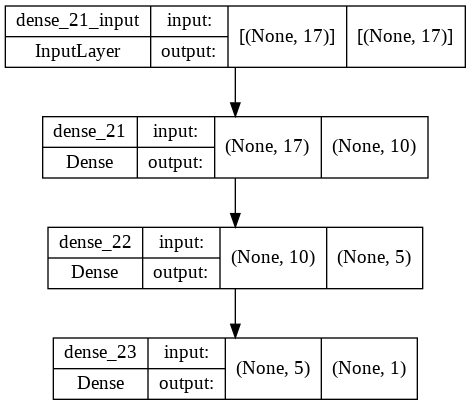

In [43]:
# Get Pic
model2 = Sequential()
model2.add(Dense(10, input_dim=17, activation='relu'))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [44]:
# No Reg
model2 = Sequential()
model2.add(Dense(10, input_dim=17, activation='relu'))
model2.add(Dense(5, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

Epoch 1/70
327/327 [==============================] - 2s 3ms/step - loss: 0.4083 - accuracy: 0.8880 - val_loss: 0.2254 - val_accuracy: 0.9499
Epoch 2/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1856 - accuracy: 0.9544 - val_loss: 0.1838 - val_accuracy: 0.9499
Epoch 3/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1649 - accuracy: 0.9544 - val_loss: 0.1768 - val_accuracy: 0.9499
Epoch 4/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1585 - accuracy: 0.9544 - val_loss: 0.1745 - val_accuracy: 0.9499
Epoch 5/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1552 - accuracy: 0.9547 - val_loss: 0.1724 - val_accuracy: 0.9499
Epoch 6/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1525 - accuracy: 0.9547 - val_loss: 0.1708 - val_accuracy: 0.9499
Epoch 7/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1503 - accuracy: 0.9547 - val_loss: 0.1708 - val_accuracy: 0.9499
Epoch 

In [45]:
# L1 Reg
model2 = Sequential()
model2.add(Dense(10, input_dim=17, activation='relu', kernel_regularizer='l1'))
model2.add(Dense(5, activation='relu', kernel_regularizer='l1'))
model2.add(Dense(1, activation='sigmoid', kernel_regularizer='l1'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

Epoch 1/70
327/327 [==============================] - 2s 4ms/step - loss: 0.8074 - accuracy: 0.9217 - val_loss: 0.6332 - val_accuracy: 0.9499
Epoch 2/70
327/327 [==============================] - 1s 3ms/step - loss: 0.5095 - accuracy: 0.9547 - val_loss: 0.4482 - val_accuracy: 0.9499
Epoch 3/70
327/327 [==============================] - 1s 3ms/step - loss: 0.3766 - accuracy: 0.9547 - val_loss: 0.3524 - val_accuracy: 0.9499
Epoch 4/70
327/327 [==============================] - 1s 3ms/step - loss: 0.3086 - accuracy: 0.9547 - val_loss: 0.3024 - val_accuracy: 0.9499
Epoch 5/70
327/327 [==============================] - 1s 3ms/step - loss: 0.2692 - accuracy: 0.9547 - val_loss: 0.2709 - val_accuracy: 0.9499
Epoch 6/70
327/327 [==============================] - 1s 3ms/step - loss: 0.2421 - accuracy: 0.9547 - val_loss: 0.2475 - val_accuracy: 0.9499
Epoch 7/70
327/327 [==============================] - 1s 3ms/step - loss: 0.2251 - accuracy: 0.9547 - val_loss: 0.2362 - val_accuracy: 0.9499
Epoch 

In [46]:
# L2 Reg
model2 = Sequential()
model2.add(Dense(10, input_dim=17, activation='relu', kernel_regularizer='l2'))
model2.add(Dense(5, activation='relu', kernel_regularizer='l2'))
model2.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

Epoch 1/70
327/327 [==============================] - 2s 4ms/step - loss: 0.7048 - accuracy: 0.7675 - val_loss: 0.4305 - val_accuracy: 0.9499
Epoch 2/70
327/327 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.9547 - val_loss: 0.2802 - val_accuracy: 0.9499
Epoch 3/70
327/327 [==============================] - 1s 3ms/step - loss: 0.2471 - accuracy: 0.9547 - val_loss: 0.2387 - val_accuracy: 0.9499
Epoch 4/70
327/327 [==============================] - 1s 3ms/step - loss: 0.2156 - accuracy: 0.9547 - val_loss: 0.2198 - val_accuracy: 0.9499
Epoch 5/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1997 - accuracy: 0.9547 - val_loss: 0.2102 - val_accuracy: 0.9499
Epoch 6/70
327/327 [==============================] - 1s 4ms/step - loss: 0.1910 - accuracy: 0.9547 - val_loss: 0.2048 - val_accuracy: 0.9499
Epoch 7/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1863 - accuracy: 0.9547 - val_loss: 0.2018 - val_accuracy: 0.9499
Epoch 

# Model 3

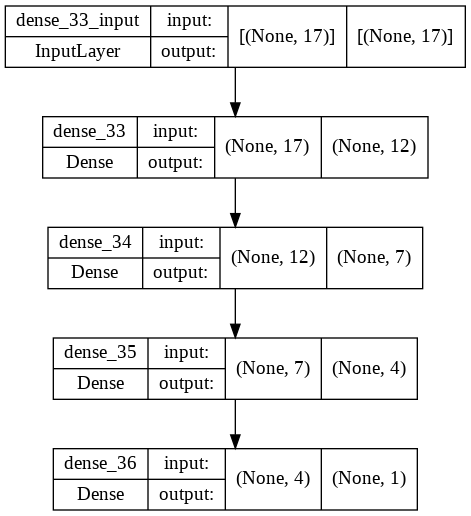

In [47]:
# Get Pic
model = Sequential()
model.add(Dense(12, input_dim=17, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [48]:
# No Reg
model = Sequential()
model.add(Dense(12, input_dim=17, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

Epoch 1/70
327/327 [==============================] - 1s 4ms/step - loss: 0.1785 - accuracy: 0.9547 - val_loss: 0.1979 - val_accuracy: 0.9499
Epoch 2/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1786 - accuracy: 0.9547 - val_loss: 0.1977 - val_accuracy: 0.9499
Epoch 3/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1971 - val_accuracy: 0.9499
Epoch 4/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1969 - val_accuracy: 0.9499
Epoch 5/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1787 - accuracy: 0.9547 - val_loss: 0.1975 - val_accuracy: 0.9499
Epoch 6/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1787 - accuracy: 0.9547 - val_loss: 0.1974 - val_accuracy: 0.9499
Epoch 7/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1785 - accuracy: 0.9547 - val_loss: 0.1973 - val_accuracy: 0.9499
Epoch 

In [49]:
# L1 Reg
model = Sequential()
model.add(Dense(12, input_dim=17, activation='relu', kernel_regularizer='l1'))
model.add(Dense(7, activation='relu', kernel_regularizer='l1'))
model.add(Dense(4, activation='relu', kernel_regularizer='l1'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l1'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

Epoch 1/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1783 - accuracy: 0.9547 - val_loss: 0.1980 - val_accuracy: 0.9499
Epoch 2/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1787 - accuracy: 0.9547 - val_loss: 0.1972 - val_accuracy: 0.9499
Epoch 3/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1978 - val_accuracy: 0.9499
Epoch 4/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1785 - accuracy: 0.9547 - val_loss: 0.1976 - val_accuracy: 0.9499
Epoch 5/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1975 - val_accuracy: 0.9499
Epoch 6/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1781 - accuracy: 0.9547 - val_loss: 0.1968 - val_accuracy: 0.9499
Epoch 7/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1785 - accuracy: 0.9547 - val_loss: 0.1969 - val_accuracy: 0.9499
Epoch 

In [50]:
# L2 Reg
model = Sequential()
model.add(Dense(12, input_dim=17, activation='relu', kernel_regularizer='l2'))
model.add(Dense(7, activation='relu', kernel_regularizer='l2'))
model.add(Dense(4, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_80, y_train_80, epochs=70, batch_size=10, validation_split=0.2)

Epoch 1/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1975 - val_accuracy: 0.9499
Epoch 2/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1782 - accuracy: 0.9547 - val_loss: 0.1986 - val_accuracy: 0.9499
Epoch 3/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1789 - accuracy: 0.9547 - val_loss: 0.1977 - val_accuracy: 0.9499
Epoch 4/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1978 - val_accuracy: 0.9499
Epoch 5/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1972 - val_accuracy: 0.9499
Epoch 6/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1784 - accuracy: 0.9547 - val_loss: 0.1971 - val_accuracy: 0.9499
Epoch 7/70
327/327 [==============================] - 1s 3ms/step - loss: 0.1783 - accuracy: 0.9547 - val_loss: 0.1985 - val_accuracy: 0.9499
Epoch 